# complex network (Acetyl-CoA gene TF)


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import scanpy as sc
import anndata as ad


/Users/yuanzan/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### network data prepare

In [3]:
raw = pd.read_excel("/Users/yuanzan/Documents/phd/tomato_metabolic/作图2.19/网络图/CoA-gene-TF相关性.xlsx", sheet_name=0, index_col=0)
fpkm_data = raw.loc[:,raw.columns.isin(['type', 'Family', 'r', 'ID'])==False]
raw.loc['Acetyl-CoA', 'r'] = 1
raw['absCorr'] = abs(raw['r'])

corr_data = fpkm_data.T.corr()
corr_data['gene'] = corr_data.index
corr_data.columns.name = None
corr_data.index.name = None
corr_data = corr_data.melt(id_vars=['gene'])
corr_data.columns = ['name1', 'name2', 'corr']
corr_data['type1'] = raw.loc[corr_data['name1'].to_list(), 'type'].to_list()
corr_data['type2'] = raw.loc[corr_data['name2'].to_list(), 'type'].to_list()
corr_data['absCorr'] = abs(corr_data['corr'])

In [4]:
corr_data_plot = corr_data[corr_data['name1'].isin(raw.query('type=="gene"').index)]
corr_data_plot = corr_data_plot[corr_data_plot['name2'].isin(raw.query('type=="TF"').index)]
#corr_data_plot = corr_data_plot.query('absCorr>=0.6')
corr_data_plot.head(2)

,name1,name2,corr,type1,type2,absCorr
681,SlACS1,SlB3.1,-0.396226,gene,TF,0.396226
682,SlACS2,SlB3.1,0.769729,gene,TF,0.769729


* 网络图：
1. Acetyl-CoA --> gene     >=0.6用实线，0.4-0.6用虚线，
2. Acetyl-CoA --> TF        >=0.6用实线，0.4-0.6用虚线，
3. gene --> TF                  >=0.6画线
4. gene --> gene    没画
4. TF --> TF    没画

* \>=0.6用实线，0.4-0.6用虚线，
* 正负调控不用分别做线，
* gene和TF之间相关性取>=0.6画实线。

In [5]:
corr_data_plot.to_csv("gene_TF.corr.csv", index=False, sep="\t")

# position

In [6]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(5,5)})

## umap

<AxesSubplot: xlabel='UMAP 1', ylabel='UMAP 2'>

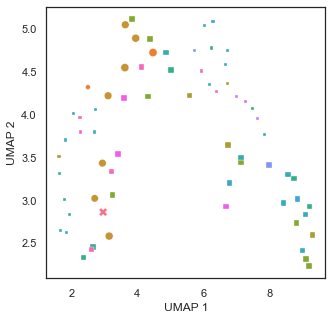

In [7]:
import umap
reducer = umap.UMAP(random_state=2)

scaled_data = StandardScaler().fit_transform(fpkm_data)

embedding = reducer.fit_transform(scaled_data)
embedding.shape

raw['UMAP 1'] = embedding[:, 0]
raw['UMAP 2'] = embedding[:, 1]

sns.scatterplot(data=raw, x='UMAP 1', y='UMAP 2', 
                style='type', hue='Family',
                size='r', legend=False, 
                style_order=['gene', 'metabolite', 'TF'])

## PCA

In [202]:
"""
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(fpkm_data)
X_reduction = pca.transform(fpkm_data)

raw['PC1'] = X_reduction[:, 0]
raw['PC2'] = X_reduction[:, 1]
"""

"\nfrom sklearn.decomposition import PCA\npca = PCA(n_components=2)\npca.fit(fpkm_data)\nX_reduction = pca.transform(fpkm_data)\n\nraw['PC1'] = X_reduction[:, 0]\nraw['PC2'] = X_reduction[:, 1]\n"

In [8]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatch
keys = list(mcolors.CSS4_COLORS)


# network style1

In [9]:
def draw_CoA_edge(df, G, pos, edge_color='#E00671', alpha=1):
    df = df.query('absCorr>=0.4')
    c_edges_pos = []
    c_edges_neg = []
    for i,row in df.iterrows():
        G.add_edge('Acetyl-CoA', i, length=row['absCorr'], weight=row['absCorr'])
        if row['absCorr'] >= 0.6:
            c_edges_pos.append(('Acetyl-CoA', i))
        else:
            c_edges_neg.append(('Acetyl-CoA', i))
            
    nx.draw_networkx_edges(G, pos, edgelist=c_edges_pos, edge_color=edge_color, alpha=alpha, style = 'solid')
    nx.draw_networkx_edges(G, pos, edgelist=c_edges_neg, edge_color=edge_color, alpha=alpha, style = 'dashed')
    
def draw_TF_gene_edge(df, G, pos, edge_color='#E00671', alpha=1):
    df = df[df['absCorr']>=0.6]
    c_edges = []
    for i,row in df.iterrows():
        G.add_edge(row['name1'], row['name2'], length=row['absCorr'], weight=row['absCorr'])
        c_edges.append((row['name1'], row['name2']))
    
    nx.draw_networkx_edges(G, pos, edgelist=c_edges, edge_color=edge_color, alpha=alpha, style = 'solid')
    

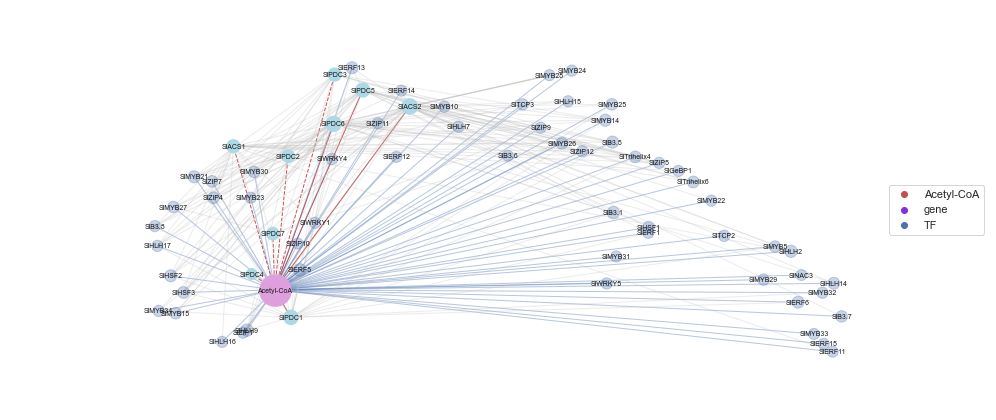

In [16]:
plt.figure(1, figsize=(14, 6))
G = nx.Graph()
G.clear()
pos = {raw.index[i]:embedding[i] for i in range(raw.shape[0])}
#pos['Acetyl-CoA'] = np.array([8,8])

for i in raw.index:
    G.add_node(i)
    
    

#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
props = dict(fontweight='bold')
nx.draw_networkx_labels(G, pos, labels={i:i for i in pos}, font_size=7, font_family="Arial", font_color='k')
    
nx.draw_networkx_nodes(G, pos, nodelist=['Acetyl-CoA'], node_size=1000, node_color='#DDA0DD')
nx.draw_networkx_nodes(G, pos, nodelist=raw.query('type=="gene"').index, node_size=raw.query('type=="gene"')['absCorr']*300, node_color='#ADD8E6')


#for i,v in enumerate(raw.query('type=="TF"')['Family'].unique()):
#    nx.draw_networkx_nodes(G, pos, nodelist=raw[raw['Family']==v].index, node_size=raw[raw['Family']==v]['absCorr']*300, node_color=keys[i])
    
    
nx.draw_networkx_nodes(G, pos, nodelist=raw.query('type=="TF"').index, node_size=raw.query('type=="TF"')['absCorr']*200, node_color='b', alpha=0.3)


draw_CoA_edge(raw.query('type=="gene"'), G, pos, edge_color='r', alpha=1)
draw_CoA_edge(raw.query('type=="TF"'), G, pos, edge_color='b', alpha=0.4)
draw_TF_gene_edge(corr_data_plot, G, pos, edge_color='silver', alpha=0.3)


ax = plt.gca()
ax.scatter(None,None, label='Acetyl-CoA', color='r')
ax.scatter(None,None, label='gene', color='blueviolet')
ax.scatter(None,None, label='TF', color='b')
#for i,v in enumerate(raw.query('type=="TF"')['Family'].unique()):
#    ax.scatter(None,None, label=v, color=keys[i])
    
     
ax.legend(loc=5)

ax.margins(0.15)
plt.axis("off")
plt.tight_layout()

plt.savefig("network_CoA.pdf")


aliceblue
antiquewhite
aqua
aquamarine
azure
beige
bisque
black
blanchedalmond
blue
blueviolet


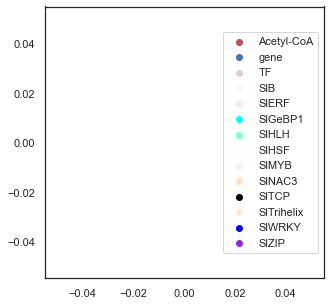

In [170]:
ax = plt.gca()
ax.scatter(None,None, label='Acetyl-CoA', color='r')
ax.scatter(None,None, label='gene', color='b')
ax.scatter(None,None, label='TF', color='#E0CCD2')
for i,v in enumerate(raw.query('type=="TF"')['Family'].unique()):
    print(keys[i])
    ax.scatter(None,None, label=v, color=keys[i])
    
    
ax.legend(loc=5)


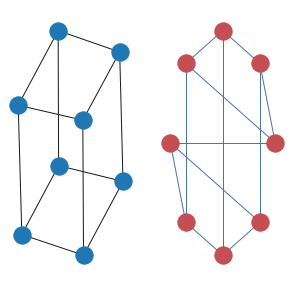

In [84]:

import matplotlib.pyplot as plt
G = nx.cubical_graph()
subax1 = plt.subplot(121)
nx.draw(G)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')